In [ ]:
!curl https://data.deepai.org/mnist.zip -o mnist.zip
!unzip mnist.zip -d mnist/
!rm mnist.zip
!gunzip mnist -r

In [112]:
!ls mnist

t10k-images-idx3-ubyte  train-images-idx3-ubyte
t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [162]:
import numpy as np

def load_mnist_data(test=False):
    if(test):
        f_images = open('mnist/t10k-images-idx3-ubyte','rb')
        f_labels = open('mnist/t10k-labels-idx1-ubyte','rb')
    else:
        f_images = open('mnist/train-images-idx3-ubyte','rb')
        f_labels = open('mnist/train-labels-idx1-ubyte','rb')
        
    
    
    # skip bullshit start
    f_images.seek(16)
    f_labels.seek(8)
    
    # read whole file
    buf_images = f_images.read()
    buf_labels = f_labels.read()
    
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(-1, 1, 28, 28) / 256
    
    labels = np.frombuffer(buf_labels, dtype=np.uint8)
    labels_one_hot = np.zeros((labels.shape[0], 10))
    labels_one_hot[np.arange(labels.size), labels] = 1
    
    return images, labels

def sample_batch(X, Y, batch_size=32):
    length = len(Y)
    idx = np.random.choice(np.arange(0, length), size=(batch_size), replace=False)
    
    return X[idx], Y[idx]

## USAGE EXAMPLE:
#  X, Y = load_mnist_data(test=False)
#  x, y = sample_batch(X, Y)

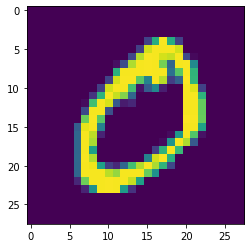

In [163]:
from matplotlib.pyplot import imshow

imshow(data[1])

In [180]:
import torch
from torch import nn, optim

model = nn.Linear(28 * 28, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [181]:
from tqdm import trange

X, Y = load_mnist_data(test=False)
X_LENGTH = len(X)
EPOCHS = 10
BATCH_SIZE = 256
DEVICE = 'cpu'

for epoch in range(EPOCHS):
    print('EPOCH', epoch)
    for _ in trange(X_LENGTH // BATCH_SIZE):
        optimizer.zero_grad()
        
        x, y = sample_batch(X, Y, BATCH_SIZE)
        x = torch.from_numpy(x).float().to(DEVICE)
        y = torch.from_numpy(y).long().to(DEVICE)
        
        y_ = model(x.view((BATCH_SIZE, 28 * 28)))
        loss = nn.CrossEntropyLoss()(y_, y)
        
        loss.backward()
        optimizer.step()
        
        if(_ == 10):
            print(loss)



  0%|          | 0/234 [00:00<?, ?it/s]

 19%|█▉        | 45/234 [00:00<00:00, 441.28it/s]

EPOCH 0
tensor(1.8861, grad_fn=<NllLossBackward>)




 38%|███▊      | 90/234 [00:00<00:00, 381.25it/s]

 55%|█████▌    | 129/234 [00:00<00:00, 382.43it/s]

 74%|███████▎  | 172/234 [00:00<00:00, 398.91it/s]

100%|██████████| 234/234 [00:00<00:00, 397.83it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 20%|██        | 47/234 [00:00<00:00, 463.51it/s]

EPOCH 1
tensor(0.4755, grad_fn=<NllLossBackward>)




 40%|████      | 94/234 [00:00<00:00, 433.35it/s]

 59%|█████▉    | 138/234 [00:00<00:00, 388.13it/s]

 77%|███████▋  | 181/234 [00:00<00:00, 400.54it/s]

100%|██████████| 234/234 [00:00<00:00, 399.13it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 16%|█▌        | 38/234 [00:00<00:00, 377.83it/s]

EPOCH 2
tensor(0.4235, grad_fn=<NllLossBackward>)




 35%|███▌      | 83/234 [00:00<00:00, 419.71it/s]

 55%|█████▌    | 129/234 [00:00<00:00, 435.99it/s]

 74%|███████▍  | 173/234 [00:00<00:00, 421.06it/s]

100%|██████████| 234/234 [00:00<00:00, 409.22it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 16%|█▌        | 37/234 [00:00<00:00, 364.22it/s]

EPOCH 3
tensor(0.2555, grad_fn=<NllLossBackward>)




 33%|███▎      | 77/234 [00:00<00:00, 382.84it/s]

 50%|█████     | 118/234 [00:00<00:00, 392.74it/s]

 68%|██████▊   | 158/234 [00:00<00:00, 387.66it/s]

100%|██████████| 234/234 [00:00<00:00, 397.02it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 18%|█▊        | 43/234 [00:00<00:00, 427.20it/s]

EPOCH 4
tensor(0.3573, grad_fn=<NllLossBackward>)




 37%|███▋      | 86/234 [00:00<00:00, 389.13it/s]

 54%|█████▍    | 126/234 [00:00<00:00, 372.89it/s]

 71%|███████▏  | 167/234 [00:00<00:00, 386.18it/s]

100%|██████████| 234/234 [00:00<00:00, 380.14it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 16%|█▌        | 37/234 [00:00<00:00, 360.80it/s]

EPOCH 5
tensor(0.3904, grad_fn=<NllLossBackward>)




 34%|███▍      | 79/234 [00:00<00:00, 393.24it/s]

 51%|█████     | 119/234 [00:00<00:00, 388.80it/s]

 68%|██████▊   | 160/234 [00:00<00:00, 396.69it/s]

100%|██████████| 234/234 [00:00<00:00, 376.71it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 19%|█▉        | 45/234 [00:00<00:00, 447.64it/s]

EPOCH 6
tensor(0.3237, grad_fn=<NllLossBackward>)




 39%|███▉      | 91/234 [00:00<00:00, 453.07it/s]

 59%|█████▊    | 137/234 [00:00<00:00, 451.79it/s]

 78%|███████▊  | 183/234 [00:00<00:00, 425.20it/s]

100%|██████████| 234/234 [00:00<00:00, 424.91it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 17%|█▋        | 40/234 [00:00<00:00, 397.20it/s]

EPOCH 7
tensor(0.3459, grad_fn=<NllLossBackward>)




 35%|███▍      | 81/234 [00:00<00:00, 400.87it/s]

 54%|█████▍    | 126/234 [00:00<00:00, 422.88it/s]

 74%|███████▍  | 173/234 [00:00<00:00, 439.48it/s]

100%|██████████| 234/234 [00:00<00:00, 432.18it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 19%|█▉        | 45/234 [00:00<00:00, 449.29it/s]

EPOCH 8
tensor(0.2702, grad_fn=<NllLossBackward>)




 39%|███▉      | 91/234 [00:00<00:00, 453.32it/s]

 59%|█████▉    | 138/234 [00:00<00:00, 457.04it/s]

 79%|███████▊  | 184/234 [00:00<00:00, 436.79it/s]

100%|██████████| 234/234 [00:00<00:00, 446.83it/s]


  0%|          | 0/234 [00:00<?, ?it/s]

 19%|█▉        | 45/234 [00:00<00:00, 447.94it/s]

EPOCH 9
tensor(0.3153, grad_fn=<NllLossBackward>)




 39%|███▉      | 92/234 [00:00<00:00, 456.01it/s]

 59%|█████▉    | 138/234 [00:00<00:00, 431.56it/s]

 78%|███████▊  | 182/234 [00:00<00:00, 434.03it/s]

100%|██████████| 234/234 [00:00<00:00, 429.10it/s]
